# Importer les bibliotheque necessire

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import metrics
import sys

## 1. Chargement et EDA

In [3]:
iris = load_iris(as_frame=True)
df = iris.frame
print("Aperçu des données ")
print(df.head(), "\n")
print("Infos")
df.info()
print("\n Statistiques descriptives")
print(df.describe().T)

Aperçu des données 
   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

   target  
0       0  
1       0  
2       0  
3       0  
4       0   

Infos
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-n

## Distribution de la cible

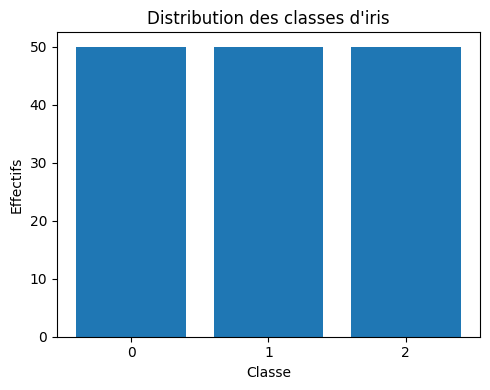

In [4]:
counts = df[iris.target.name].value_counts()
plt.figure(figsize=(5,4))
plt.bar(counts.index.astype(str), counts.values)
plt.title("Distribution des classes d'iris")
plt.xlabel("Classe")
plt.ylabel("Effectifs")
plt.tight_layout()
plt.show()

## Histogrammes de quelques features

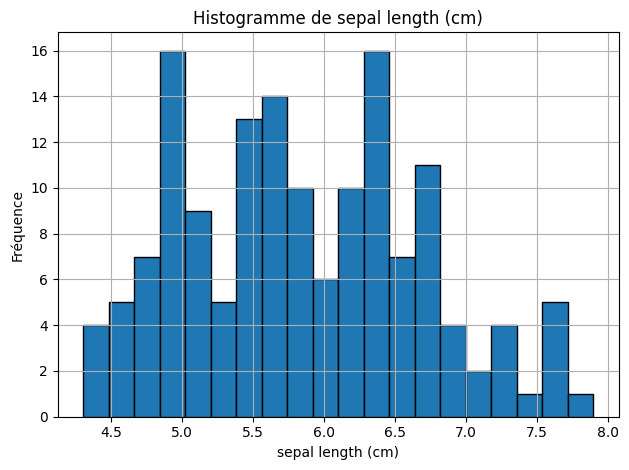

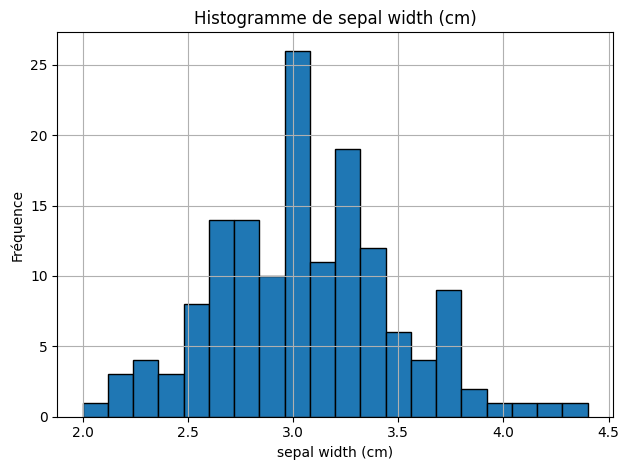

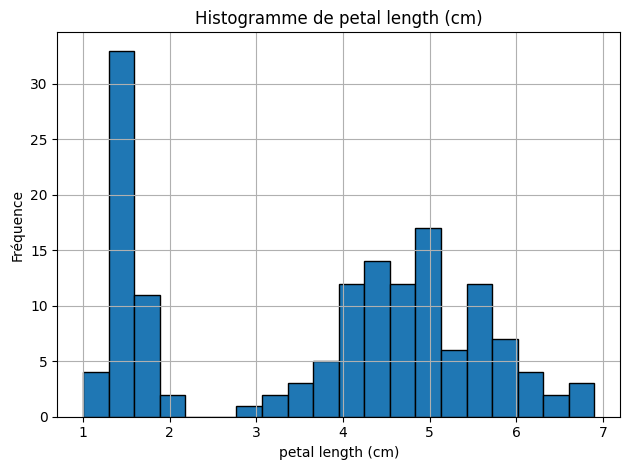

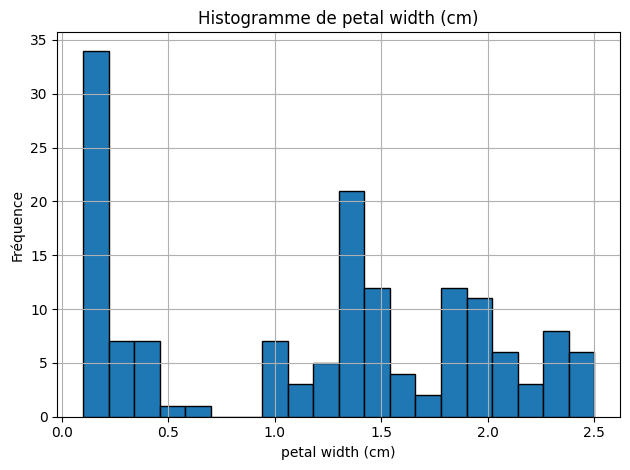

In [5]:
for feat in df.columns[:-1]:
    plt.figure()
    df[feat].hist(bins=20, edgecolor='black')
    plt.title(f"Histogramme de {feat}")
    plt.xlabel(feat)
    plt.ylabel("Fréquence")
    plt.tight_layout()
    plt.show()

## Matrice de corrélation

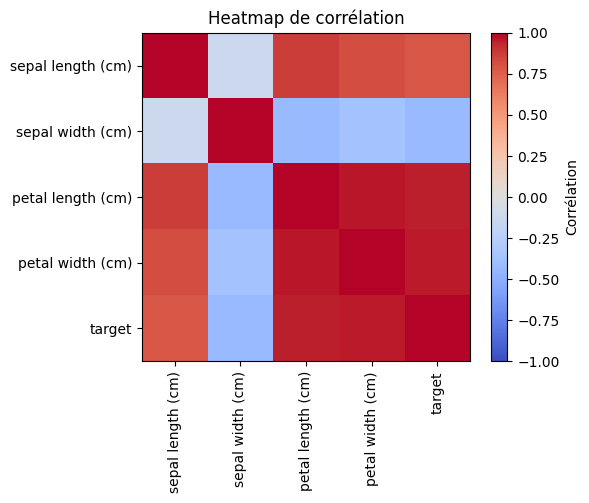

In [6]:
corr = df.corr()
plt.figure(figsize=(6,5))
plt.imshow(corr, vmin=-1, vmax=1, cmap='coolwarm', interpolation='nearest')
plt.colorbar(label="Corrélation")
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.index)
plt.title("Heatmap de corrélation")
plt.tight_layout()
plt.show()

## 2. Prétraitement et entraînement

In [7]:
X = df.drop(columns=[iris.target.name])
y = df[iris.target.name]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

## Recherche d'hyperparamètres

In [8]:
param_grid = {'C': [0.1, 1, 10], 'gamma': ['scale', 'auto']}
grid = GridSearchCV(SVC(kernel='rbf', probability=True), param_grid, cv=5)
grid.fit(X_train_s, y_train)
model = grid.best_estimator_
print(f"Meilleurs paramètres: {grid.best_params_}")

Meilleurs paramètres: {'C': 1, 'gamma': 'scale'}


## 3. Évaluation

In [9]:
y_pred = model.predict(X_test_s)
print(f"Accuracy: {metrics.accuracy_score(y_test, y_pred):.2%}")
print("Classification report:\n", metrics.classification_report(y_test, y_pred, target_names=iris.target_names))
print("Matrice de confusion:\n", metrics.confusion_matrix(y_test, y_pred))

Accuracy: 100.00%
Classification report:
               precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       1.00      1.00      1.00        13
   virginica       1.00      1.00      1.00        13

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45

Matrice de confusion:
 [[19  0  0]
 [ 0 13  0]
 [ 0  0 13]]


## Courbe ROC multiclasses

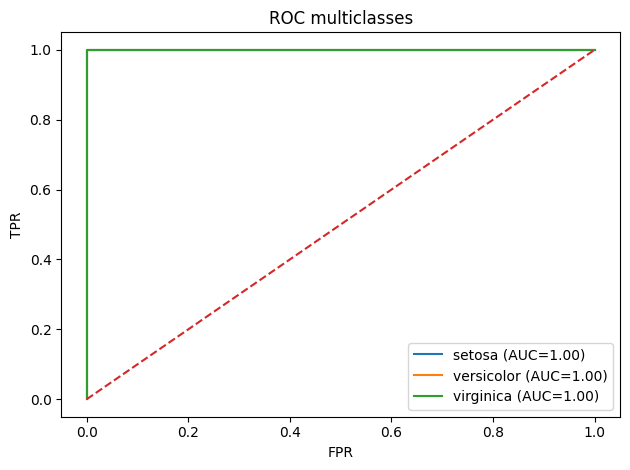

In [10]:
if hasattr(model, 'predict_proba'):
    y_proba = model.predict_proba(X_test_s)
    for i, cname in enumerate(iris.target_names):
        fpr, tpr, _ = metrics.roc_curve((y_test == i).astype(int), y_proba[:, i])
        auc_score = metrics.auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{cname} (AUC={auc_score:.2f})")
    plt.plot([0, 1], [0, 1], '--')
    plt.title("ROC multiclasses")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.legend()
    plt.tight_layout()
    plt.show()

## 4. Prédiction interactive console

In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

# —————— Création dynamique des sliders pour chaque feature ——————
sliders = {}
for feat in X.columns:
    min_val = float(df[feat].min())
    max_val = float(df[feat].max())
    step = (max_val - min_val) / 100  # 100 pas
    sliders[feat] = widgets.FloatSlider(
        value=df[feat].mean(),
        min=min_val,
        max=max_val,
        step=step,
        description=feat,
        continuous_update=False,
        layout=widgets.Layout(width='600px')
    )

# Bouton et zone de sortie
predict_button = widgets.Button(description="Prédire (SVM)", button_style='info')
output = widgets.Output()

# Fonction de prédiction améliorée
@output.capture(clear_output=True)
def on_predict_clicked(b):
    # Récupérer les valeurs depuis les sliders
    sample = [slider.value for slider in sliders.values()]
    # Normalisation
    sample_scaled = scaler.transform([sample])
    # Prédiction de la classe
    pred = model.predict(sample_scaled)[0]
    # Probabilités pour toutes les classes
    probs = model.predict_proba(sample_scaled)[0]
    # Affichage
    print(f"Classe prédite : {iris.target_names[pred]}\n")
    print("Probabilités par classe :")
    for i, cls in enumerate(iris.target_names):
        print(f"  - {cls:<10}: {probs[i]:.2%}")

# Liaison et affichage
predict_button.on_click(on_predict_clicked)
ui_items = list(sliders.values()) + [predict_button, output]
display(widgets.VBox(ui_items))